In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [2]:
%ls ./data/processed

# T12H-X850M-Y880M_2013-01-01_2015-01-01/
# T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
# T1H-X850M-Y880M_2013-01-01_2015-01-01/
# T24H-X255M-Y220M_2013-01-01_2015-01-01/
# T24H-X425M-Y440M_2013-01-01_2015-01-01/
# T24H-X850M-Y880M_2013-01-01_2015-01-01/
# T24H-X85M-Y110M_2013-01-01_2015-01-01/
# T3H-X850M-Y880M_2013-01-01_2015-01-01/
# T6H-X850M-Y880M_2013-01-01_2015-01-01/

T12H-X850M-Y880M_2013-01-01_2015-01-01/
T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
T1H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X255M-Y220M_2013-01-01_2015-01-01/
T24H-X425M-Y440M_2013-01-01_2015-01-01/
T24H-X850M-Y880M_2013-01-01_2015-01-01/
T24H-X85M-Y110M_2013-01-01_2015-01-01/
T3H-X850M-Y880M_2013-01-01_2015-01-01/
T6H-X850M-Y880M_2013-01-01_2015-01-01/


In [0]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork, SmallKangFNN

from dataloaders.flat_loader import FlatDataLoaders, MockLoader, MockLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, PerTimeStepPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models, get_models_metrics
from utils.mock_data import mock_fnn_data_classification
from utils.plots import im
from utils.utils import pshape
from trainers.generic_trainer import train_model
from models.kangkang_fnn_models import train_epoch_for_fnn

from utils.metrics import best_threshold, get_y_pred

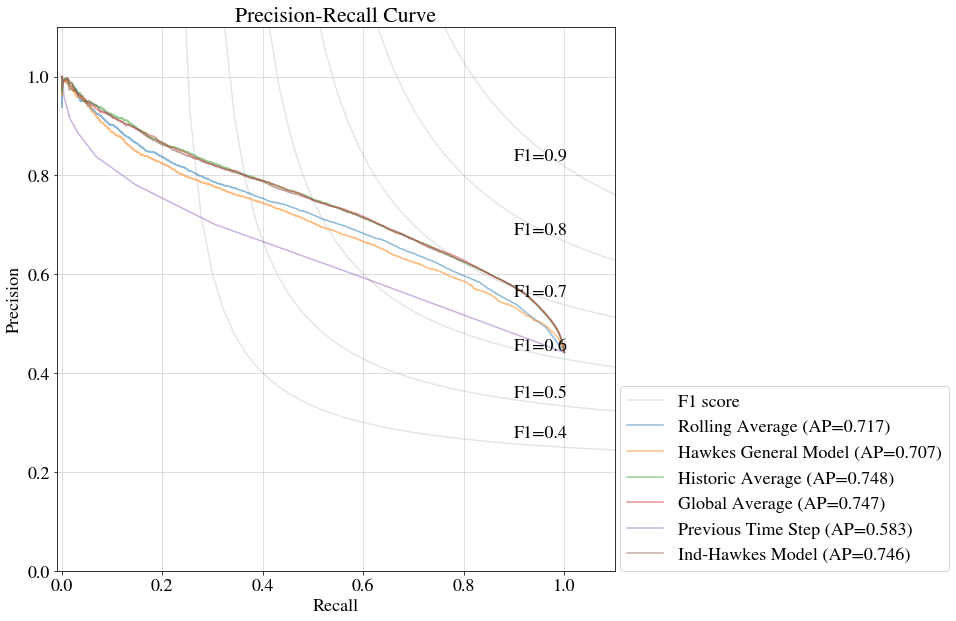

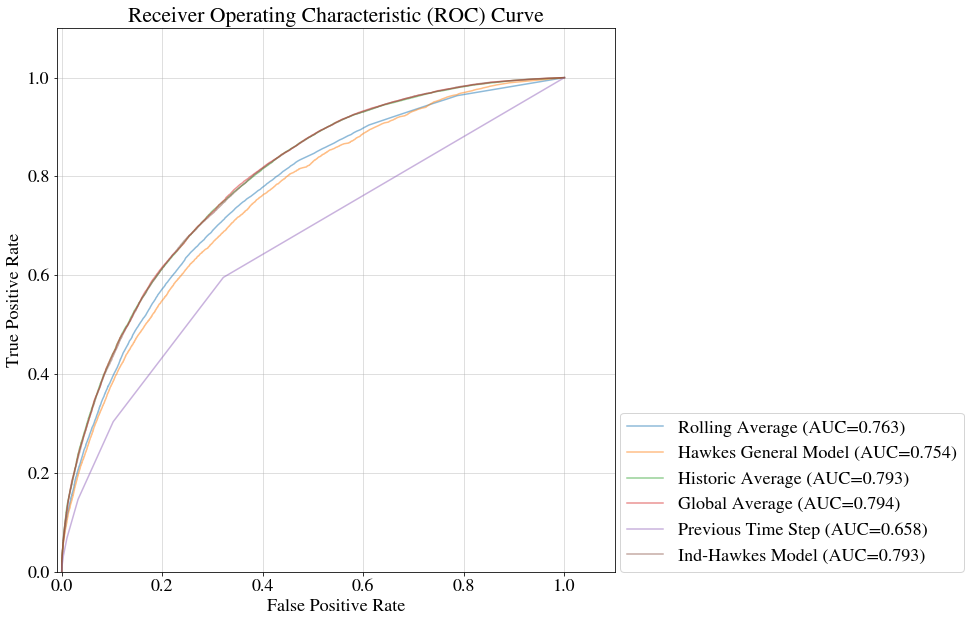

2019-11-05T11:33:09 | root | INFO | =====================================BEGIN=====================================
2019-11-05T11:33:09 | root | INFO | Device: cuda:0


In [4]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M" # "T24H-X85M-Y110M" #"T1H-X1700M-Y1760M"  # needs to exist  
model_name = "Kang FNN"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"
compare_models(data_path=data_path)

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": True,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

In [0]:
log.getLogger().setLevel("WARNING")

In [0]:
log.getLogger().setLevel("INFO")

2019-11-05T12:20:05 | root | INFO | 	t_range shape (731,)
2019-11-05T12:20:05 | root | INFO | Start Training Kang FNN
2019-11-05T12:20:05 | root | INFO | Using optimiser: 
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 1e-08
)


2019-11-05T12:20:05 | root | INFO | Epoch: 0001/0100
2019-11-05T12:20:12 | root | INFO | 	Loss (Trn): 	0.57946
2019-11-05T12:20:12 | root | INFO | 	Loss (Val): 	0.57281
2019-11-05T12:20:12 | root | INFO | 	Loss (Dif): 	0.00664

2019-11-05T12:20:12 | root | INFO | Epoch: 0002/0100
2019-11-05T12:20:19 | root | INFO | 	Loss (Trn): 	0.55970
2019-11-05T12:20:19 | root | INFO | 	Loss (Val): 	0.56593
2019-11-05T12:20:19 | root | INFO | 	Loss (Dif): 	0.00622

2019-11-05T12:20:19 | root | INFO | Epoch: 0003/0100
2019-11-05T12:20:26 | root | INFO | 	Loss (Trn): 	0.55519
2019-11-05T12:20:26 | root | INFO | 	Loss (Val): 	0.56069
2019-11-05T12:20:26 | root | INFO | 	Loss (Dif): 	0.00551

2019-11-05T12:20:26

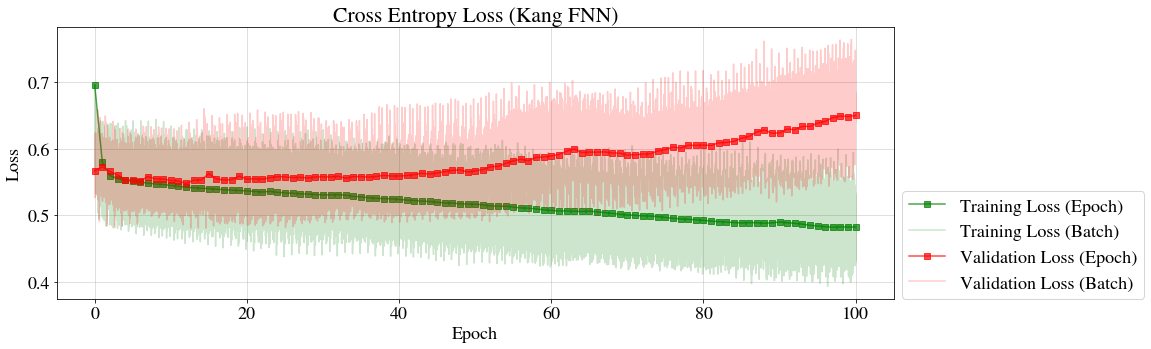

In [23]:
# SET THE HYPER PARAMETERS
conf.early_stopping = False
conf.max_epochs = 20
conf.dropout = 0#0.2
conf.weight_decay = 1e-8
conf.resume = False
conf.checkpoint = "best" # ["best"|"latest"]
conf.lr = 1e-3
conf.shaper_top_k = -1
conf.batch_size =  256

MOCK = False

if MOCK:
    # MOCK THE DATA
    vector_size= [5,5,5]#[37,65,512]    
    class_split=0.5
    train_loader = MockLoader(vector_size, conf.batch_size, n_samples=1000, class_split=class_split)
    validation_loader = MockLoader(vector_size, conf.batch_size, n_samples=200, class_split=class_split)
    test_loader = MockLoader(vector_size, conf.batch_size, n_samples=300, class_split=class_split)
    loaders = MockLoaders(train_loader,validation_loader,test_loader)
else:
    # CRIME DATA
    conf.sub_sample_test_set = False
    conf.sub_sample_train_set = True
    conf.sub_sample_validation_set = True

    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)

conf.freqstr = data_group.t_range.freqstr    

# SET LOSS FUNCTION
# size averaged - so more epochs or larger lr for smaller batches
loss_function = nn.CrossEntropyLoss()  

# SETUP MODEL
train_set = loaders.train_loader.dataset
indices, spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]


model_arch = {
    "h_size0": 100,
    "h_size1": 100,
    "h_size2": 100,
}
model = SmallKangFNN(spc_size=spc_size,
                     tmp_size=tmp_size,
                     env_size=env_size,
                     dropout_p=conf.dropout,
                     model_arch=model_arch)

# model_arch = {
#     "scp_net_h0": 64,
#     "scp_net_h1": 32,
#     "tmp_net_h0": 64,
#     "tmp_net_h1": 32,
#     "env_net_h0": 64,
#     "env_net_h1": 32,
#     "final_net_h1": 64,
# }
# model = KangFeedForwardNetwork(spc_size=spc_size,
#                                  tmp_size=tmp_size,
#                                  env_size=env_size,
#                                  dropout_p=conf.dropout,
#                                  model_arch=model_arch)

model.to(conf.device)

# SETUP OPTIMISER
parameters = model.parameters()

# important note: using weight decay (l2 penalty) can prohibit long term memory in LSTM networks
# - use gradient clipping instead
optimiser = optim.Adam(params=parameters, lr=conf.lr, weight_decay=conf.weight_decay)

##### RESUME LOGIC
if conf.resume:  # todo check if the files actually exist
    try:
        # resume from previous check point or resume from best validaton score checkpoint
        # load model state
        model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                      map_location=conf.device.type)
        model.load_state_dict(model_state_dict)
        
        # load optimiser state
        optimiser_state_dict = torch.load(f"{conf.model_path}optimiser_{conf.checkpoint}.pth",
                                          map_location=conf.device.type)
        optimiser.load_state_dict(optimiser_state_dict) 

        # new optimiser hyper-parameters
        optimiser.param_groups[0]['lr'] = conf.lr
        optimiser.param_groups[0]['weight_decay'] = conf.weight_decay

        # new model hyper-parameters
        model.dropout.p = conf.dropout # note that drop out is not part of the saved state dict

    except Exception as e:
        log.error(f"Nothing to resume from, training from scratch \n\t-> {e}")

trn_epoch_losses, val_epoch_losses, stopped_early = train_model(model=model,
                                                                     optimiser=optimiser,
                                                                     loaders=loaders,
                                                                     train_epoch_fn=train_epoch_for_fnn,
                                                                     loss_fn=loss_function,
                                                                     conf=conf)    

print(f"stopped_early: {stopped_early}") # use the current epoch instead
# if stopped_early -> continue with best_model - new hyper-parameters -> no n 

In [0]:
log.getLogger().setLevel("INFO")

# Evaluation

In [41]:
# Load latest or best validation model
# conf.checkpoint = "best"
conf.checkpoint = "latest"

log.info(f"Loading model from checkpoint ({conf.checkpoint}) for evaluation")

# resume from previous check point or resume from best validaton score checkpoint
# load model state
model_state_dict = torch.load(f"{conf.model_path}model_{conf.checkpoint}.pth",
                                map_location=conf.device.type)
model.load_state_dict(model_state_dict)

2019-11-05T13:55:03 | root | INFO | Loading model from checkpoint (latest) for evaluation


<All keys matched successfully>

In [0]:
conf.sub_sample_test_set = False
conf.sub_sample_train_set = False
conf.sub_sample_validation_set = False

loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-05T13:55:16 | root | INFO | f1_score: 0.7214589027723546 at index 63537, new threshold 0.41617318987846375
2019-11-05T13:55:19 | root | INFO | 
        MODEL METRICS
            Model Name: Kang FNN
                ROC AUC:            0.7621214823481705
                Recall:             0.8191117328204232
                Precision:          0.5875577481865502
                Average Precision:  0.7068947999823774
                Accuracy:           0.6659841343429661
                MCC:                0.3715324683931275          
        
2019-11-05T13:55:19 | root | INFO | 
        MODEL RESULT
            Model Name: Kang FNN
                ROC AUC:            0.7621214823481705
                Recall:             0.8191117328204232
                Precision:          0.5875577481865502
                Average Precision:  0.7068947999823774
                Accuracy:           0.6659841343429661
                MCC:                0.3715324683931275          
        


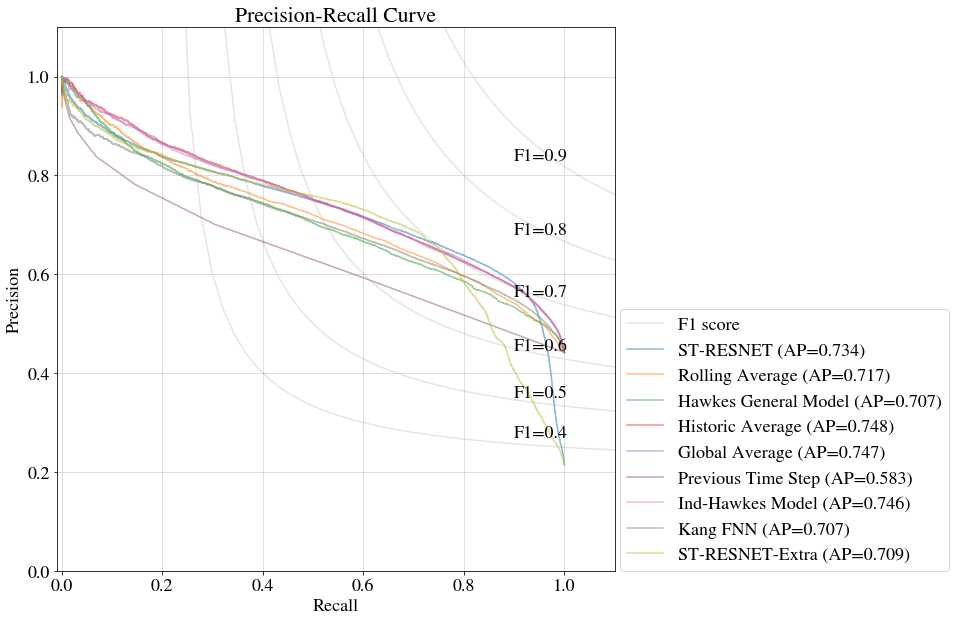

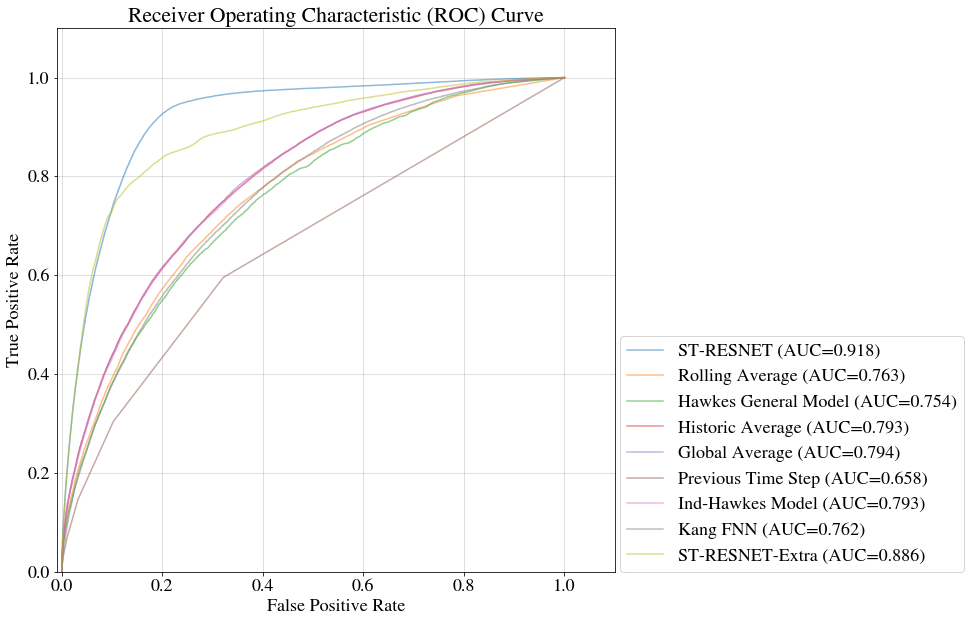

In [43]:
def evaluate_fnn(model, batch_loader, conf):    
    """
    Only used to get probas in a time and location based format. The hard predictions should be done outside 
    this function where the threshold is determined using only the training data
    """
    probas_pred = np.zeros(batch_loader.dataset.target_shape,dtype=np.float)
    y_true = batch_loader.dataset.targets[-len(probas_pred):]
    t_range = batch_loader.dataset.t_range[-len(probas_pred):]
    
    
    with torch.set_grad_enabled(False):
        model.eval()
            
        num_batches = batch_loader.num_batches
        for indices, spc_feats, tmp_feats, env_feats, targets in batch_loader:
            current_batch = batch_loader.current_batch

            # Transfer to PyTorch Tensor and GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(conf.device) # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(conf.device) # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(conf.device) # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(conf.device) # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            batch_probas_pred = F.softmax(out,dim=-1)[:,1].cpu().numpy() # select class1 prediction
            
            for i, p in zip(indices,batch_probas_pred):
                n,c,l = i   
                probas_pred[n,c,l] = p

    
    return y_true, probas_pred, t_range


# todo set the train_loader to eval so that it does not subsample
trn_y_true, trn_probas_pred, trn_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.train_loader,
                                                        conf=conf)

thresh = best_threshold(y_true=trn_y_true,
                       probas_pred=trn_probas_pred)

tst_y_true, tst_probas_pred, tst_t_range = evaluate_fnn(model=model,
                                                        batch_loader=loaders.test_loader,
                                                        conf=conf)    
    
    

tst_y_pred = get_y_pred(thresh, tst_probas_pred)    
    
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)   

compare_models(data_path=data_path)

In [0]:
model_metrics = get_models_metrics(data_path)



In [0]:
m = model_metrics[0]

In [69]:
a = "5.4234234243"
f"{a:.3d}"

ValueError: ignored

In [77]:
metric_keys = ['model_name', 'accuracy_score', 'roc_auc_score', 'average_precision_score', 'recall_score', 'precision_score', 'matthews_corrcoef']


'model_name, m.accuracy_score, m.roc_auc_score, m.average_precision_score, m.recall_score, m.precision_score, m.matthews_corrcoef'

In [0]:

col = ['Accuracy','ROC AUC','Average Precision','Recall','Precision','Matthews Corrcoef']
data = []
names = []
for m in model_metrics:
    names.append(m.model_name)
    row = [m.accuracy_score, m.roc_auc_score, m.average_precision_score, m.recall_score, m.precision_score, m.matthews_corrcoef]
    data.append(row)
    table += f"\n|{m.model_name}| {m.accuracy_score}| {m.roc_auc_score}| {m.average_precision_score}| {m.recall_score}| {m.precision_score}| {m.matthews_corrcoef}|"



In [0]:
import pandas as pd

In [92]:
df = pd.DataFrame(columns=col,data=data,index=names)
print(df.sort_index().to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  Accuracy &   ROC AUC &  Average Precision &    Recall &  Precision &  Matthews Corrcoef \\
\midrule
Global Average       &  0.679828 &  0.793560 &           0.746980 &  0.860057 &   0.595336 &           0.410530 \\
Hawkes General Model &  0.660653 &  0.753543 &           0.707105 &  0.804511 &   0.584266 &           0.357392 \\
Historic Average     &  0.676171 &  0.792898 &           0.747870 &  0.870548 &   0.590636 &           0.409349 \\
Ind-Hawkes Model     &  0.684194 &  0.792523 &           0.745954 &  0.849653 &   0.600899 &           0.413194 \\
Kang FNN             &  0.665984 &  0.762121 &           0.706895 &  0.819112 &   0.587558 &           0.371532 \\
Previous Time Step   &  0.441895 &  0.658416 &           0.583346 &  1.000000 &   0.441895 &           0.000000 \\
Rolling Average      &  0.663718 &  0.763296 &           0.717494 &  0.830361 &   0.584052 &           0.372131 \\
ST-RESNET            &  0.862626 &  0.918287 &         

In [40]:
from time import sleep
timer = Timer()
timer.reset()
i = 0
for v in loaders.train_loader:
    i += 1
print(f"i: {i} and train loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.validation_loader:
    i += 1
print(f"i: {i} and val loader time {timer.check()}")    

timer.reset()
i = 0
for v in loaders.test_loader:
    i += 1
print(f"i: {i} and test loader time {timer.check()}")    

i: 616 and train loader time 3.225488
i: 102 and val loader time 0.536836
i: 304 and test loader time 1.579159


In [0]:
from sklearn.metrics import precision_recall_curve


def safe_f1_score(pr):
    p, r = pr
    if p + r == 0:
        return 0
    else:
        return 2 * (p * r) / (p + r)

precision, recall, thresholds = precision_recall_curve(trn_y_true.flatten(), trn_probas_pred.flatten())
precision, recall, thresholds = precision_recall_curve(tst_y_true.flatten(), tst_probas_pred.flatten())
scores = np.array(list(map(safe_f1_score, zip(precision, recall))))
index_array = np.argmax(scores)  # almost always a singular int, and not an array

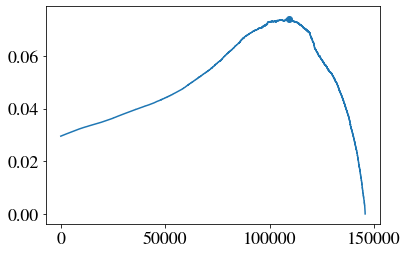

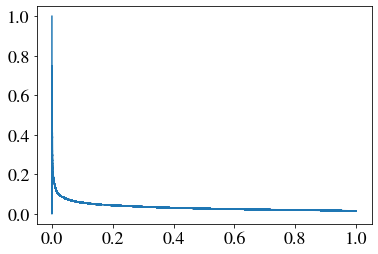

In [0]:
plt.plot(scores)
plt.scatter(index_array,scores[index_array])
plt.show()

plt.plot(recall, precision)
plt.scatter(recall, precision, s=scores*5,alpha=.1)
plt.show()

**Metrics per cell**

ap_per_cell



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


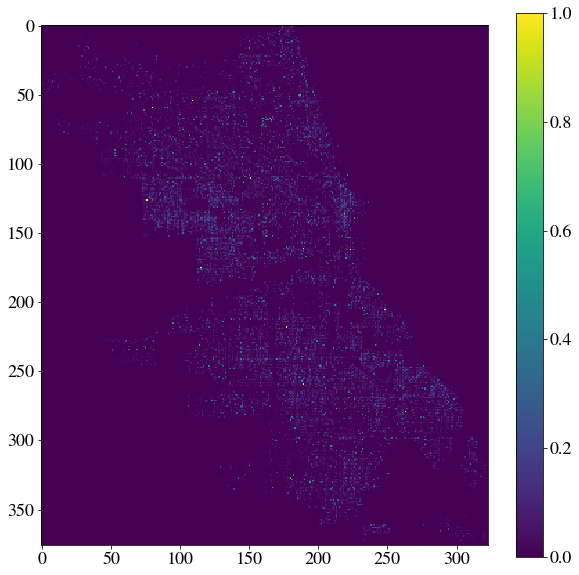

roc_per_cell



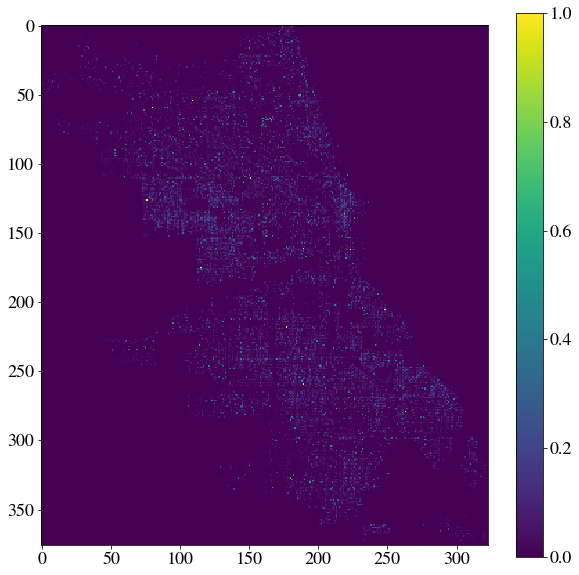

p_per_cell



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


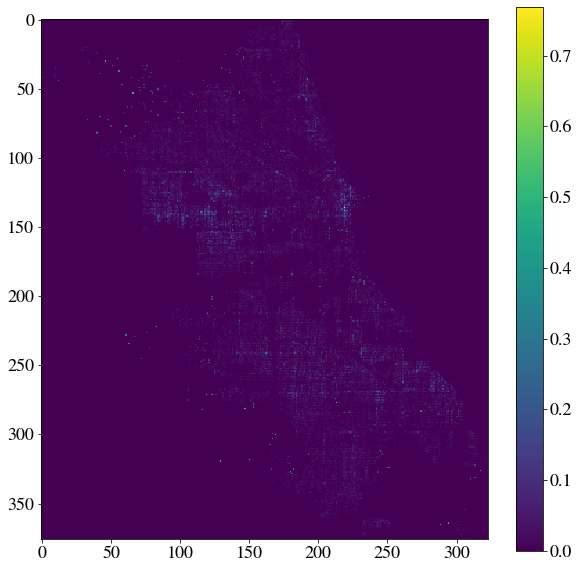

r_per_cell



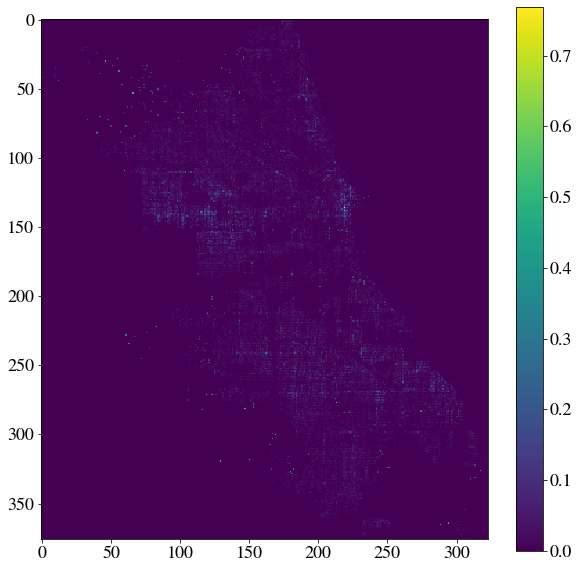

In [0]:
print("ap_per_cell\n")
ap_per_cell = average_precision_score_per_cell(tst_y_true, tst_probas_pred)
ap_per_cell = np.nan_to_num(ap_per_cell)
ap_per_cell = data_group.shaper.unsqueeze(ap_per_cell)[0,0]
im(ap_per_cell)

print("roc_per_cell\n")
roc_per_cell = roc_auc_score_per_cell(tst_y_true, tst_probas_pred)
roc_per_cell = np.nan_to_num(roc_per_cell)
roc_per_cell = data_group.shaper.unsqueeze(roc_per_cell)[0,0]
im(roc_per_cell)

print("p_per_cell\n")
p_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
p_per_cell = data_group.shaper.unsqueeze(p_per_cell)[0,0]
im(p_per_cell)

print("r_per_cell\n")
r_per_cell = precision_score_per_cell(tst_y_true, tst_y_pred)
r_per_cell = data_group.shaper.unsqueeze(r_per_cell)[0,0]
im(r_per_cell)

**Metrics per time slot**: should be one plot per metric - with multiple models

In [0]:
import matplotlib.pyplot as plt

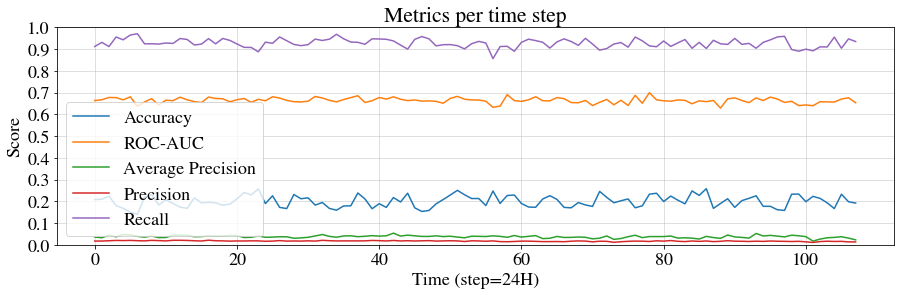

In [0]:
freqstr = data_group.t_range.freqstr

N = tst_y_true.shape[0]

ap_per_time = average_precision_score_per_time_slot(y_true=tst_y_true,
                                                    probas_pred=tst_probas_pred)

ap_per_time = np.nan_to_num(ap_per_time)

roc_per_time = roc_auc_score_per_time_slot(y_true=tst_y_true,
                                           probas_pred=tst_probas_pred)
roc_per_time = np.nan_to_num(roc_per_time)

acc_per_time = accuracy_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
acc_per_time = np.nan_to_num(acc_per_time)

p_per_time = precision_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
p_per_time = np.nan_to_num(p_per_time)

r_per_time = recall_score_per_time_slot(y_true=tst_y_true,
                                           y_pred=tst_y_pred)
r_per_time = np.nan_to_num(r_per_time)


plt.figure(figsize=(15,4))
plt.plot(acc_per_time[:,0,0],label="Accuracy")
plt.plot(roc_per_time[:,0,0],label="ROC-AUC")
plt.plot(ap_per_time[:,0,0],label="Average Precision")
plt.plot(p_per_time[:,0,0],label="Precision")
plt.plot(r_per_time[:,0,0],label="Recall")
plt.title("Metrics per time step")
plt.ylabel("Score")
plt.xlabel(f"Time (step={freqstr})")
plt.ylim([0,1])
# plt.xlim([0,N-1])
plt.yticks(np.arange(11)/10)



plt.legend()
plt.grid(True,alpha=0.5)
plt.show()

In [0]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, recall_score, precision_score, accuracy_score

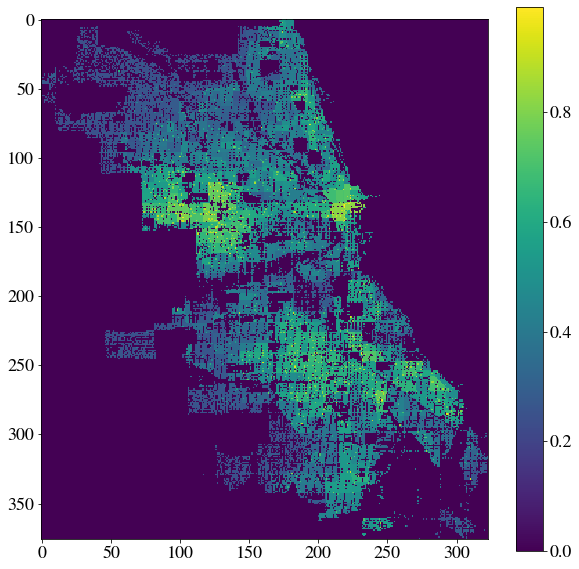

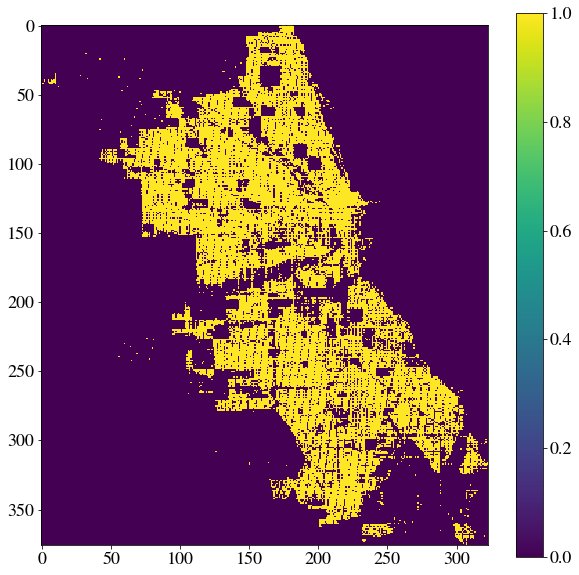

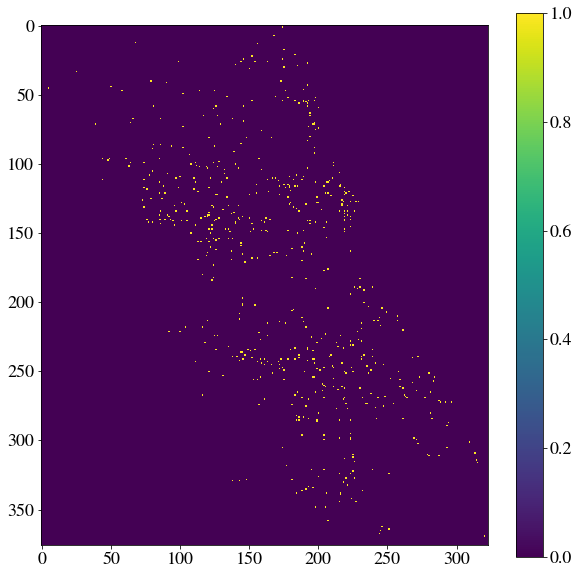

In [0]:
im(data_group.shaper.unsqueeze(tst_probas_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_pred)[40][0])
im(data_group.shaper.unsqueeze(tst_y_true)[40][0])
# im(data_group.shaper.unsqueeze(loaders.test_loader.dataset.targets)[40][0])

In [0]:
loaders.test_loader.dataset.targets.shape

In [0]:
targets = loaders.data_group.testing_set.targets

# todo get better name
probas_grid = np.zeros_like(targets)

In [0]:

###### testing ###### torch outputs to see if we're actually getting valuable things out
out = torch.Tensor([[-3,2],[2,-1],[0.5,0.4]])
print(out.shape)
print(out)
out_soft = F.softmax(out, dim=-1)
print(out_soft)
out_label = torch.argmax(out_soft, dim=-1)
print(out_label)



In [0]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
conf.batch_size = 4
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    
    # loop through is set does not fit in batch
    for indices, spc_feats, tmp_feats, env_feats, targets in loaders.test_loader: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(conf.device)
        tmp_feats = torch.Tensor(tmp_feats).to(conf.device)
        env_feats = torch.Tensor(env_feats).to(conf.device)
        targets = torch.LongTensor(targets).to(conf.device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
                        
        out = F.softmax(out, dim=-1)
        
        log.info(f"out: {out}")
        log.info(f"indices: {indices}")
        log.info(f"indices: {targets}")
    
        out_label = torch.argmax(out, dim=-1)
        log.info(f"out_label: {out_label}")
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())
        
        break  # !! remove


# todo change to be the shape (N,L) of the original prediction.        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.test_loader.dataset.t_range,
                            shaper=loaders.data_group.shaper)
                        
# log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

In [0]:
pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")targets.shape